This notebook is intends to check the TensorFlow saved model is working properly. It is on purpose independant from the `mrcnn` package so the code can be ported more easily to other languages such as Java,

In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tifffile
import tensorflow as tf
from skimage import color
from skimage import transform

root_dir = Path("/home/hadim/.data/Neural_Network/Mask-RCNN/Microtubules/")
saved_model_dir = root_dir / "saved_model"

model_name = "coco_512_new"

# Configurations
BATCH_SIZE = 1

IMAGE_RESIZE_MODE = "square"
IMAGE_MIN_DIM = 10
IMAGE_MAX_DIM = 512
MIN_SCALE = 1
MEAN_PIXEL = [123.7, 116.8, 103.9]
CLASS_IDS = ["BG", "microtubule"]
IMAGE_SHAPE = [IMAGE_MAX_DIM, IMAGE_MAX_DIM, 3]

BACKBONE = "resnet50"
BACKBONE_STRIDES = [4, 8, 16, 32, 64]
RPN_ANCHOR_SCALES = [8, 16, 32, 64, 128]
RPN_ANCHOR_RATIOS = [0.5, 1, 2]
RPN_ANCHOR_STRIDE = 1

INPUT_NODE_IMAGE_NAME = "input_image"
INPUT_NODE_IMAGE_METADATA_NAME = "input_image_meta"
INPUT_NODE_ANCHORS_NAME = "input_anchors"
OUTPUT_NODE_NAMES = ["detections", "mrcnn_class", "mrcnn_bbox", "mrcnn_mask", "rois"]

tf_model_path = saved_model_dir / f"tf_model_{model_name}.pb"
assert tf_model_path.is_file()

/home/hadim/local/conda/envs/nn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load Image

In [2]:
image_dir = Path("/home/hadim/Documents/Code/Postdoc/ij/testdata/")
image_path = image_dir / "fake-flat-corrected.tif"
#image_path = image_dir / "7,5uM_emccd_lapse1-small-8bit-Single.tif"
#image_path = image_dir / "test-tracking-single.tif"
#image_path = image_dir / "test-tracking.tif"

original_images = tifffile.imread(str(image_path))
if len(original_images.shape) == 2:
    original_images = np.expand_dims(original_images, 0)
original_images.shape

(1, 200, 200)

# Preprocess Image

In [7]:
images = color.gray2rgb(original_images)
molded_images, image_metas, windows = mold_inputs(images)

# Generate anchors
anchors = get_anchors(IMAGE_SHAPE, BACKBONE, BACKBONE_STRIDES, RPN_ANCHOR_SCALES,
                      RPN_ANCHOR_RATIOS, RPN_ANCHOR_STRIDE, BATCH_SIZE)

molded_images.shape

(1, 512, 512, 3)

Text(0.5,1,'Processed Image')

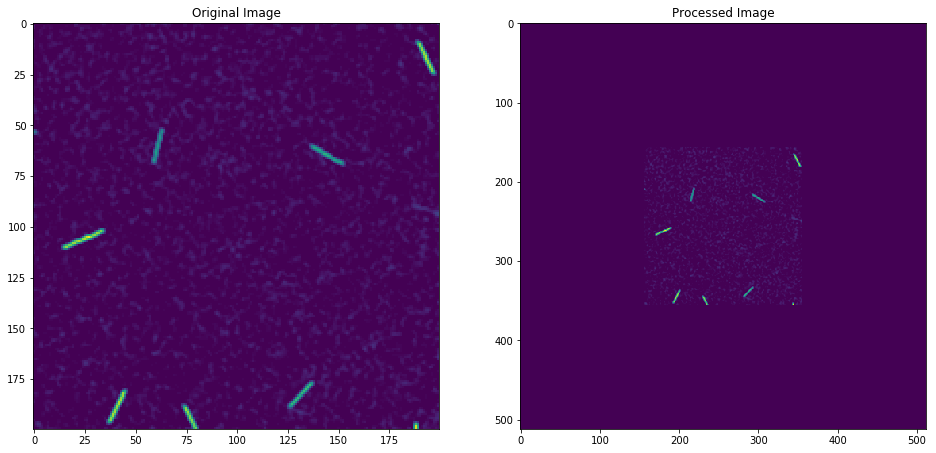

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 8))
axs[0].imshow(original_images[0, :, :], interpolation="none")
axs[0].set_title("Original Image")
axs[1].imshow(molded_images[0, :, :, 0], interpolation="none")
axs[1].set_title("Processed Image")

# Load Model and Run Prediction

In [9]:
with tf.gfile.FastGFile(str(tf_model_path), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

In [10]:
with tf.Session() as sess:
    
    # Prepare inputs and outputs
    input_image_tensor = sess.graph.get_tensor_by_name(f'{INPUT_NODE_IMAGE_NAME}:0')
    input_image_metadat_tensor = sess.graph.get_tensor_by_name(f'{INPUT_NODE_IMAGE_METADATA_NAME}:0')
    input_anchor_tensor = sess.graph.get_tensor_by_name(f'{INPUT_NODE_ANCHORS_NAME}:0')
    
    input_data = {input_image_tensor: molded_images,
                  input_image_metadat_tensor: image_metas,
                  input_anchor_tensor: anchors}

    output_data = {node_name: sess.graph.get_tensor_by_name(f'output_{node_name}:0')
                   for node_name in OUTPUT_NODE_NAMES}
    
    # Run the prediction
    raw_results = sess.run(fetches=output_data, feed_dict=input_data)

# Postprocess Results

In [11]:
results = []
for i, image in enumerate(molded_images):

    detections = raw_results["detections"][i]
    mrcnn_mask = raw_results["mrcnn_mask"][i]
    original_image_shape = original_images[i].shape
    image_shape = image.shape
    window = windows[i]
    
    result = unmold_detections(detections, mrcnn_mask, original_image_shape, image_shape, window)
    results.append(result)

Text(0.5,1,'Result')

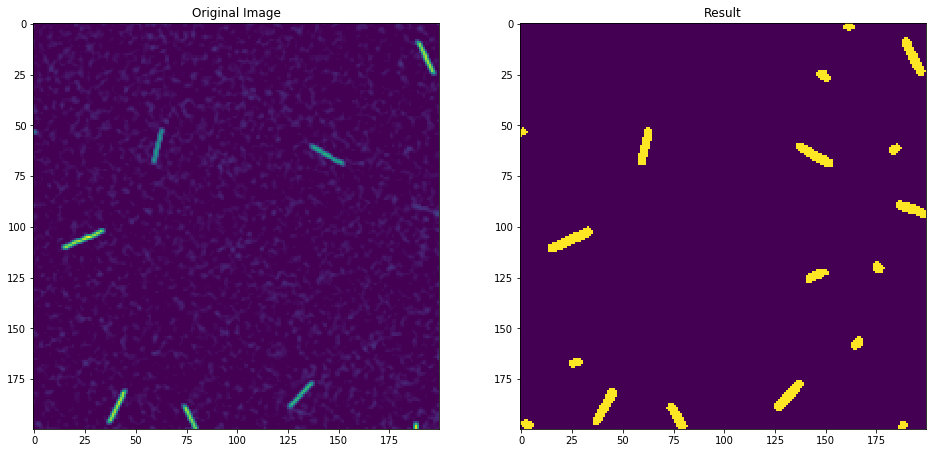

In [12]:
# Display masks

fig, axs = plt.subplots(ncols=2, figsize=(16, 8))
axs[0].imshow(original_images[0, :, :], interpolation="none")
axs[0].set_title("Original Image")
axs[1].imshow(np.max(results[0]["masks"], axis=2), interpolation="none")
axs[1].set_title("Result")

In [5]:
def compute_backbone_shapes(image_shape, backbone, backbone_strides):
    """Computes the width and height of each stage of the backbone network.
    
    Returns:
        [N, (height, width)]. Where N is the number of stages
    """
    # Currently supports ResNet only
    assert backbone in ["resnet50", "resnet101"]
    return np.array(
        [[int(np.ceil(image_shape[0] / stride)),
            int(np.ceil(image_shape[1] / stride))]
            for stride in backbone_strides])
    
def generate_pyramid_anchors(scales, ratios, feature_shapes, feature_strides,
                             anchor_stride):
    """Generate anchors at different levels of a feature pyramid. Each scale
    is associated with a level of the pyramid, but each ratio is used in
    all levels of the pyramid.
    Returns:
    anchors: [N, (y1, x1, y2, x2)]. All generated anchors in one array. Sorted
        with the same order of the given scales. So, anchors of scale[0] come
        first, then anchors of scale[1], and so on.
    """
    # Anchors
    # [anchor_count, (y1, x1, y2, x2)]
    anchors = []
    for i in range(len(scales)):
        anchors.append(generate_anchors(scales[i], ratios, feature_shapes[i],
                                        feature_strides[i], anchor_stride))
    return np.concatenate(anchors, axis=0)

def generate_anchors(scales, ratios, shape, feature_stride, anchor_stride):
    """
    scales: 1D array of anchor sizes in pixels. Example: [32, 64, 128]
    ratios: 1D array of anchor ratios of width/height. Example: [0.5, 1, 2]
    shape: [height, width] spatial shape of the feature map over which
            to generate anchors.
    feature_stride: Stride of the feature map relative to the image in pixels.
    anchor_stride: Stride of anchors on the feature map. For example, if the
        value is 2 then generate anchors for every other feature map pixel.
    """
    # Get all combinations of scales and ratios
    scales, ratios = np.meshgrid(np.array(scales), np.array(ratios))
    scales = scales.flatten()
    ratios = ratios.flatten()

    # Enumerate heights and widths from scales and ratios
    heights = scales / np.sqrt(ratios)
    widths = scales * np.sqrt(ratios)

    # Enumerate shifts in feature space
    shifts_y = np.arange(0, shape[0], anchor_stride) * feature_stride
    shifts_x = np.arange(0, shape[1], anchor_stride) * feature_stride
    shifts_x, shifts_y = np.meshgrid(shifts_x, shifts_y)

    # Enumerate combinations of shifts, widths, and heights
    box_widths, box_centers_x = np.meshgrid(widths, shifts_x)
    box_heights, box_centers_y = np.meshgrid(heights, shifts_y)

    # Reshape to get a list of (y, x) and a list of (h, w)
    box_centers = np.stack(
        [box_centers_y, box_centers_x], axis=2).reshape([-1, 2])
    box_sizes = np.stack([box_heights, box_widths], axis=2).reshape([-1, 2])

    # Convert to corner coordinates (y1, x1, y2, x2)
    boxes = np.concatenate([box_centers - 0.5 * box_sizes,
                            box_centers + 0.5 * box_sizes], axis=1)
    return boxes

def get_anchors(image_shape, backbone, backbone_strides, rpn_anchor_scales,
                rpn_anchor_ratios, rpn_anchor_stride, batch_size):
        """Returns anchor pyramid for the given image size."""
        backbone_shapes = compute_backbone_shapes(image_shape, backbone, backbone_strides)

        # Cache anchors and reuse if image shape is the same
        # Generate Anchors
        anchors = generate_pyramid_anchors(rpn_anchor_scales, rpn_anchor_ratios,
                                     backbone_shapes, backbone_strides, rpn_anchor_stride)
        # Normalize coordinates
        anchors = norm_boxes(anchors, image_shape[:2])
    
        anchors = np.broadcast_to(anchors, (batch_size,) + anchors.shape)
        
        return anchors

In [6]:
import skimage

def unmold_detections(detections, mrcnn_mask, original_image_shape, image_shape, window):
    """Reformats the detections of one image from the format of the neural
    network output to a format suitable for use in the rest of the
    application.
    detections: [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
    mrcnn_mask: [N, height, width, num_classes]
    original_image_shape: [H, W, C] Original image shape before resizing
    image_shape: [H, W, C] Shape of the image after resizing and padding
    window: [y1, x1, y2, x2] Pixel coordinates of box in the image where the real
            image is excluding the padding.
    Returns:
    boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
    class_ids: [N] Integer class IDs for each bounding box
    scores: [N] Float probability scores of the class_id
    masks: [height, width, num_instances] Instance masks
    """
    # How many detections do we have?
    # Detections array is padded with zeros. Find the first class_id == 0.
    zero_ix = np.where(detections[:, 4] == 0)[0]
    N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

    # Extract boxes, class_ids, scores, and class-specific masks
    boxes = detections[:N, :4]
    class_ids = detections[:N, 4].astype(np.int32)
    scores = detections[:N, 5]
    masks = mrcnn_mask[np.arange(N), :, :, class_ids]

    # Translate normalized coordinates in the resized image to pixel
    # coordinates in the original image before resizing
    window = norm_boxes(window, image_shape[:2])
    wy1, wx1, wy2, wx2 = window
    shift = np.array([wy1, wx1, wy1, wx1])
    wh = wy2 - wy1  # window height
    ww = wx2 - wx1  # window width
    scale = np.array([wh, ww, wh, ww])
    # Convert boxes to normalized coordinates on the window
    boxes = np.divide(boxes - shift, scale)
    # Convert boxes to pixel coordinates on the original image
    boxes = denorm_boxes(boxes, original_image_shape[:2])

    # Filter out detections with zero area. Happens in early training when
    # network weights are still random
    exclude_ix = np.where(
        (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
    if exclude_ix.shape[0] > 0:
        boxes = np.delete(boxes, exclude_ix, axis=0)
        class_ids = np.delete(class_ids, exclude_ix, axis=0)
        scores = np.delete(scores, exclude_ix, axis=0)
        masks = np.delete(masks, exclude_ix, axis=0)
        N = class_ids.shape[0]

    # Resize masks to original image size and set boundary threshold.
    full_masks = []
    for i in range(N):
        # Convert neural network mask to full size mask
        full_mask = unmold_mask(masks[i], boxes[i], original_image_shape)
        full_masks.append(full_mask)
    full_masks = np.stack(full_masks, axis=-1)\
        if full_masks else np.empty(masks.shape[1:3] + (0,))

    result = {}
    result["rois"] = boxes
    result["class_ids"] = class_ids
    result["scores"] = scores
    result["masks"] = full_masks
    return result

def norm_boxes(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [N, (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels
    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.
    Returns:
        [N, (y1, x1, y2, x2)] in normalized coordinates
    """
    h, w = shape
    scale = np.array([h - 1, w - 1, h - 1, w - 1])
    shift = np.array([0, 0, 1, 1])
    return np.divide((boxes - shift), scale).astype(np.float32)


def denorm_boxes(boxes, shape):
    """Converts boxes from normalized coordinates to pixel coordinates.
    boxes: [N, (y1, x1, y2, x2)] in normalized coordinates
    shape: [..., (height, width)] in pixels
    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.
    Returns:
        [N, (y1, x1, y2, x2)] in pixel coordinates
    """
    h, w = shape
    scale = np.array([h - 1, w - 1, h - 1, w - 1])
    shift = np.array([0, 0, 1, 1])
    return np.around(np.multiply(boxes, scale) + shift).astype(np.int32)

def unmold_mask(mask, bbox, image_shape):
    """Converts a mask generated by the neural network to a format similar
    to its original shape.
    mask: [height, width] of type float. A small, typically 28x28 mask.
    bbox: [y1, x1, y2, x2]. The box to fit the mask in.
    Returns a binary mask with the same size as the original image.
    """
    threshold = 0.5
    y1, x1, y2, x2 = bbox
    mask = skimage.transform.resize(mask, (y2 - y1, x2 - x1), order=1, mode="constant")
    mask = np.where(mask >= threshold, 1, 0).astype(np.bool)

    # Put the mask in the right location.
    full_mask = np.zeros(image_shape[:2], dtype=np.bool)
    full_mask[y1:y2, x1:x2] = mask
    return full_mask

def resize_image(image, min_dim=None, max_dim=None, min_scale=None, mode="square"):
    """Resizes an image keeping the aspect ratio unchanged.
    min_dim: if provided, resizes the image such that it's smaller
        dimension == min_dim
    max_dim: if provided, ensures that the image longest side doesn't
        exceed this value.
    min_scale: if provided, ensure that the image is scaled up by at least
        this percent even if min_dim doesn't require it.
    mode: Resizing mode.
        none: No resizing. Return the image unchanged.
        square: Resize and pad with zeros to get a square image
            of size [max_dim, max_dim].
        pad64: Pads width and height with zeros to make them multiples of 64.
               If min_dim or min_scale are provided, it scales the image up
               before padding. max_dim is ignored in this mode.
               The multiple of 64 is needed to ensure smooth scaling of feature
               maps up and down the 6 levels of the FPN pyramid (2**6=64).
        crop: Picks random crops from the image. First, scales the image based
              on min_dim and min_scale, then picks a random crop of
              size min_dim x min_dim. Can be used in training only.
              max_dim is not used in this mode.
    Returns:
    image: the resized image
    window: (y1, x1, y2, x2). If max_dim is provided, padding might
        be inserted in the returned image. If so, this window is the
        coordinates of the image part of the full image (excluding
        the padding). The x2, y2 pixels are not included.
    scale: The scale factor used to resize the image
    padding: Padding added to the image [(top, bottom), (left, right), (0, 0)]
    """
    # Keep track of image dtype and return results in the same dtype
    image_dtype = image.dtype
    # Default window (y1, x1, y2, x2) and default scale == 1.
    h, w = image.shape[:2]
    window = (0, 0, h, w)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]
    crop = None

    if mode == "none":
        return image, window, scale, padding, crop

    # Scale?
    if min_dim:
        # Scale up but not down
        scale = max(1, min_dim / min(h, w))
    if min_scale and scale < min_scale:
        scale = min_scale

    # Does it exceed max dim?
    if max_dim and mode == "square":
        image_max = max(h, w)
        if round(image_max * scale) > max_dim:
            scale = max_dim / image_max

    # Resize image using bilinear interpolation
    if scale != 1:
        image = transform.resize(
            image, (round(h * scale), round(w * scale)),
            order=1, mode="constant", preserve_range=True)

    # Need padding or cropping?
    if mode == "square":
        # Get new height and width
        h, w = image.shape[:2]
        top_pad = (max_dim - h) // 2
        bottom_pad = max_dim - h - top_pad
        left_pad = (max_dim - w) // 2
        right_pad = max_dim - w - left_pad
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "pad64":
        h, w = image.shape[:2]
        # Both sides must be divisible by 64
        assert min_dim % 64 == 0, "Minimum dimension must be a multiple of 64"
        # Height
        if h % 64 > 0:
            max_h = h - (h % 64) + 64
            top_pad = (max_h - h) // 2
            bottom_pad = max_h - h - top_pad
        else:
            top_pad = bottom_pad = 0
        # Width
        if w % 64 > 0:
            max_w = w - (w % 64) + 64
            left_pad = (max_w - w) // 2
            right_pad = max_w - w - left_pad
        else:
            left_pad = right_pad = 0
        padding = [(top_pad, bottom_pad), (left_pad, right_pad), (0, 0)]
        image = np.pad(image, padding, mode='constant', constant_values=0)
        window = (top_pad, left_pad, h + top_pad, w + left_pad)
    elif mode == "crop":
        # Pick a random crop
        h, w = image.shape[:2]
        y = random.randint(0, (h - min_dim))
        x = random.randint(0, (w - min_dim))
        crop = (y, x, min_dim, min_dim)
        image = image[y:y + min_dim, x:x + min_dim]
        window = (0, 0, min_dim, min_dim)
    else:
        raise Exception("Mode {} not supported".format(mode))
    return image.astype(image_dtype), window, scale, padding, crop

def mold_inputs(images):
        """Takes a list of images and modifies them to the format expected
        as an input to the neural network.
        images: List of image matricies [height,width,depth]. Images can have
            different sizes.
        Returns 3 Numpy matricies:
        molded_images: [N, h, w, 3]. Images resized and normalized.
        image_metas: [N, length of meta data]. Details about each image.
        windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
            original image (padding excluded).
        """
        molded_images = []
        image_metas = []
        windows = []
        for image in images:
            # Resize image
            # TODO: move resizing to mold_image()
            molded_image, window, scale, padding, crop = resize_image(
                image,
                min_dim=IMAGE_MIN_DIM,
                min_scale=MIN_SCALE,
                max_dim=IMAGE_MAX_DIM,
                mode=IMAGE_RESIZE_MODE)
            molded_image = mold_image(molded_image)
            # Build image_meta
            image_meta = compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([len(CLASS_IDS)], dtype=np.int32))
            # Append
            molded_images.append(molded_image)
            windows.append(window)
            image_metas.append(image_meta)
        # Pack into arrays
        molded_images = np.stack(molded_images)
        image_metas = np.stack(image_metas)
        windows = np.stack(windows)
        return molded_images, image_metas, windows

def mold_image(images):
    return images.astype(np.float32) - MEAN_PIXEL

def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.
    image_id: An int ID of the image. Useful for debugging.
    original_image_shape: [H, W, C] before resizing or padding.
    image_shape: [H, W, C] after resizing and padding
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    scale: The scaling factor applied to the original image (float32)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta